## Data import and cleaning

In [40]:
#basic library import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [41]:
#Install yfinance and import Data
import yfinance as yf
from yfinance import Ticker

In [42]:
# function to obtain data from yfinance
import pandas as pd
from yfinance import Ticker
from datetime import datetime

def get_stock_data(tickers, start_date, end_date, selected_variable):
    start_date = datetime.strptime(start_date, '%d %m %Y')
    print(start_date)
    end_date = datetime.strptime(end_date, '%d %m %Y')
    print(end_date)

    dict = {}
    for ticker in tickers:
        ticker_obj = Ticker(ticker)
        history = ticker_obj.history(start=start_date, end=end_date)
        dict[ticker] = pd.DataFrame(history)
        dict[ticker] = dict[ticker][selected_variable]
        
    return dict


In [43]:
# set parameters for yfinance data

tickers = ['AAPL', 'GOOGL', 'MSFT', 'IBM', 'NVDA','META']
start_date = '01 01 2013'
end_date = '31 12 2023'

selected_variable = 'Close'

# call function to get data
stock_dict = get_stock_data(tickers, start_date, end_date, selected_variable)

2013-01-01 00:00:00
2023-12-31 00:00:00


In [44]:
# check index type
type(stock_dict['AAPL'].index)


pandas.core.indexes.datetimes.DatetimeIndex

In [45]:
print(stock_dict['IBM'].name)

Close


### Raw Data

to be removed!  
def save_dataframes_csv(df_dict, dir_path, prefix):
    for ticker, df in df_dict.items():
        #df.set_index('Date', inplace=True)
        df.to_csv(f'{dir_path}/{prefix}_{ticker}.csv', index=True, index_label='Date')
        print(f'saving {ticker}\'s {prefix} data as csv...')

In [46]:
def save_series_csv(series_dict, dir_path, prefix):
    for ticker, series in series_dict.items():
        series.to_csv(f'{dir_path}/{prefix}_{ticker}.csv')
        print(f'saving {ticker}\'s {prefix} data as csv...')

In [47]:
# saving raw data csv files
dir_path = '../data/'
prefix = 'raw'
save_series_csv(stock_dict, dir_path, prefix)

saving AAPL's raw data as csv...
saving GOOGL's raw data as csv...
saving MSFT's raw data as csv...
saving IBM's raw data as csv...
saving NVDA's raw data as csv...
saving META's raw data as csv...


## data cleanup

### format date (index)

In [48]:
from pandas import DatetimeIndex, PeriodIndex

def format_datetime_index_as_period_index(series_dict):
    #series_dict_f = series_dict.copy()
    formatted_series = {}
    summary_dates_df = pd.DataFrame(columns=['Start Date', 'End Date', 'Count'])
    for ticker, series in series_dict.items():
        if isinstance(series.index, DatetimeIndex):
            
            # print info
            first_date = series.index[0]
            last_date = series.index[-1]
            print({ticker},'Index type: ', type(series.index))
            print("First date: ", first_date, "Last date: ", last_date)
            
            new_series = pd.Series(series.values, index=series.index.to_period('D'), name=series.name) # Convert to PeriodIndex

        elif isinstance(series.index, PeriodIndex):
            new_series = series
        
        elif not isinstance(series.index, PeriodIndex):
            print(f"Error: Index for {ticker} is neither DatetimeIndex nor PeriodIndex.")
            continue
        # print info
        #first_date = series.index[0]
        #last_date = series.index[-1]
        #print({ticker},'Index type: ', type(series.index))
        #print("First date: ", first_date, "Last date: ", last_date)
        
        #create new dictionary
        formatted_series[ticker] = new_series
        summary_dates_df.loc[ticker] = [new_series.index[0], new_series.index[-1], len(new_series)]
    return formatted_series, summary_dates_df


In [49]:
formatted_data, summary_ticker_dates = format_datetime_index_as_period_index(stock_dict)

{'AAPL'} Index type:  <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
First date:  2013-01-02 00:00:00-05:00 Last date:  2023-12-29 00:00:00-05:00
{'GOOGL'} Index type:  <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
First date:  2013-01-02 00:00:00-05:00 Last date:  2023-12-29 00:00:00-05:00
{'MSFT'} Index type:  <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
First date:  2013-01-02 00:00:00-05:00 Last date:  2023-12-29 00:00:00-05:00
{'IBM'} Index type:  <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
First date:  2013-01-02 00:00:00-05:00 Last date:  2023-12-29 00:00:00-05:00
{'NVDA'} Index type:  <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
First date:  2013-01-02 00:00:00-05:00 Last date:  2023-12-29 00:00:00-05:00
{'META'} Index type:  <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
First date:  2013-01-02 00:00:00-05:00 Last date:  2023-12-29 00:00:00-05:00


/var/folders/sf/w99qq72n7ld5cplb4kcgbmxm0000gn/T/ipykernel_35769/3512245943.py:16: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  new_series = pd.Series(series.values, index=series.index.to_period('D'), name=series.name) # Convert to PeriodIndex
/var/folders/sf/w99qq72n7ld5cplb4kcgbmxm0000gn/T/ipykernel_35769/3512245943.py:16: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  new_series = pd.Series(series.values, index=series.index.to_period('D'), name=series.name) # Convert to PeriodIndex
/var/folders/sf/w99qq72n7ld5cplb4kcgbmxm0000gn/T/ipykernel_35769/3512245943.py:16: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  new_series = pd.Series(series.values, index=series.index.to_period('D'), name=series.name) # Convert to PeriodIndex
/var/folders/sf/w99qq72n7ld5cplb4kcgbmxm0000gn/T/ipykernel_35769/3512245943.py:16: UserWarning: Converting to PeriodArray

In [50]:
summary_ticker_dates

,Start Date,End Date,Count
AAPL,2013-01-02,2023-12-29,2768
GOOGL,2013-01-02,2023-12-29,2768
MSFT,2013-01-02,2023-12-29,2768
IBM,2013-01-02,2023-12-29,2768
NVDA,2013-01-02,2023-12-29,2768
META,2013-01-02,2023-12-29,2768


In [51]:
type(formatted_data['IBM'])

pandas.core.series.Series

In [52]:
print(formatted_data['IBM'].name)

Close


### format date (index)

### Missing dates

how to handle missing values?
as the stock market is closed on weekends, the values will be carried forward from the previous Friday's close price/

other options:
 
 Rolling Statistics Imputation: This method substitutes missing values with a rolling statistic (like mean, median, or mode) over a specified window period. This method can handle non-random missingness and preserve temporal dependence, but the choice of window size and statistic can significantly affect the results 1.
 
 Using pandas for rolling statistics imputation
 
window_size = 5 # adjust this value according to your needs

df_imputed = df.rolling(window_size).mean().fillna(df)

Interpolation: This method estimates missing values based on the surrounding values. Linear interpolation is suitable for linear trends, while polynomial interpolation can capture more complex trends. However, these methods can distort the data if the trend is not linear or if there's a seasonal component.

Using pandas for linear interpolation
df_imputed = df.interpolate()


In [56]:
formatted_data['IBM']

Date
2013-01-02    121.021301
2013-01-03    120.355675
2013-01-04    119.566727
2013-01-07    119.042793
2013-01-08    118.876396
                 ...    
2023-12-22    162.139999
2023-12-26    163.210007
2023-12-27    163.460007
2023-12-28    163.750000
2023-12-29    163.550003
Freq: D, Name: Close, Length: 2768, dtype: float64

In [58]:
def resample_data(dict):
    resampled_data = {}
    for ticker, series in dict.items():
        resampled_series = series.resample('D').asfreq()
        resampled_data[ticker] = resampled_series
    return resampled_data

def ffill_data(dict):
    filled_data = {}
    for ticker, series in dict.items():
        filled_series = series.ffill()
        filled_data[ticker] = filled_series
    return filled_data


In [59]:
resampled_data = resample_data(formatted_data)

In [61]:
ffilled_data = ffill_data(resampled_data)

In [63]:
data = ffilled_data

In [72]:
data_ibm_year = ffilled_data['IBM'].iloc[-365: , ]

In [73]:
data_ibm_year

Date
2022-12-30    134.223740
2022-12-31    134.223740
2023-01-01    134.223740
2023-01-02    134.223740
2023-01-03    134.852539
                 ...    
2023-12-25    162.139999
2023-12-26    163.210007
2023-12-27    163.460007
2023-12-28    163.750000
2023-12-29    163.550003
Freq: D, Name: Close, Length: 365, dtype: float64

### Clean Data

In [75]:
# saving cleaned data csv files
dir_path = '../data/'
prefix = 'cleaned'
save_series_csv(ffilled_data, dir_path, prefix)

saving AAPL's cleaned data as csv...
saving GOOGL's cleaned data as csv...
saving MSFT's cleaned data as csv...
saving IBM's cleaned data as csv...
saving NVDA's cleaned data as csv...
saving META's cleaned data as csv...


## Initial visualization

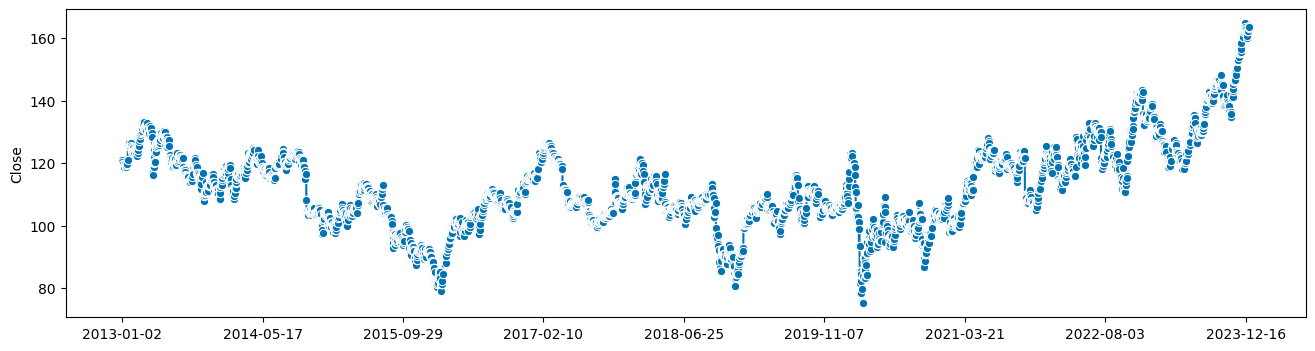

In [94]:
from sktime.utils.plotting import plot_series

# Load the airline dataset
y = data['IBM']

# Plot the time series
fig, ax = plot_series(y)


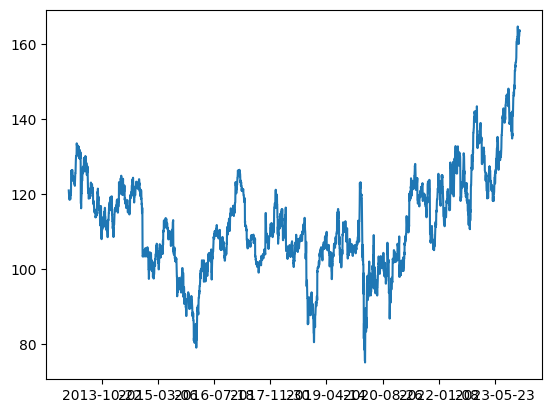

In [98]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assume df is a pandas dataframe with time series data
fig, ax = plt.subplots()
ax.plot(mdates.date2num(y.index), y.values)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.show()


In [144]:
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_series

def plot_series(dict):
    for ticker, series in dict.items():
        fig, ax = plot_series(series)
        #plt.title(f'Stock Price Time Series Plot for {ticker}')
        #plt.xlabel('Date')
        #plt.ylabel('Stock Price: Close')
        #plt.grid(True)
        #plt.show()

In [146]:
#plot_series(data)

import seaborn as sns

sns.histplot(cleaned_data['IBM'], kde=True)
plt.title('Histogram')
plt.show()


import matplotlib.pyplot as plt
import pandas as pd
from sktime.utils.plotting import plot_series

def plot_series(dict):
    pd.plotting.register_matplotlib_converters()
    for ticker, series in dict.items():
        plt.figure(figsize=(6, 2))
        plt.plot(series.index, series.values)
        plt.title(f'Stock Price Time Series Plot for {ticker}')
        plt.xlabel('Date')
        plt.ylabel('Stock Price: Close')
        plt.grid(True)
        plt.show()


# Call the function
plot_series(data)


from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

for ticker, series in data.items():
    seasonal_decompose_result = seasonal_decompose(series)
    seasonal_decompose_result.plot()
    plt.title(f'Seasonal Decomposition for {ticker}')
    plt.show()


### visualization tests

## Hypothesis testing: stationary data

We will observe and test the data to discover if it's stationary or not by:  
a) visual tests  
b) summary statistics by partition  
c) statistical tests  
    -- Dickey-Fuller (DF) test   
    -- Kwiatkowski-Phillips-Schmidt-Shin (KPSS)  

### Dickey-Fuller Test

Dickey-Fuller Test
The Dickey-Fuller (DF) test was developed and popularized by Dickey and Fuller (1979). The null hypothesis of DF test is that there is a unit root in an AR model, which implies that the data series is not stationary. The alternative hypothesis is generally stationarity or trend stationarity but can be different depending on the version of the test is being used.

Since the null hypothesis assumes the presence of unit root, that is α=1, the p-value obtained should be less than the significance level (say 0.05) in order to reject the null hypothesis. Thereby, inferring that the series is stationary.

parameters:  
“c” : constant only (default).
“ct” : constant and trend.
“ctt” : constant, and linear and quadratic trend.
“n” : no constant, no trend.


In [109]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

def adf_test(dict):
    results = []
    for ticker, series in dict.items():
        adfuller_test = adfuller(
            series,
            maxlag=None, 
            regression='c', 
            autolag='AIC', 
            store=False, 
            regresults=False)

        result = {
            'ticker': ticker,
            'ADF Statistic': adfuller_test[0],
            'p-value': adfuller_test[1],
            'used_lag': adfuller_test[2],
            'nobs': adfuller_test[3]
        }

        for key, value in adfuller_test[4].items():
            result[f'Critical Value {key}'] = value

        results.append(result)

    return pd.DataFrame(results)


In [110]:
adf_panel_results = adf_test(data)

In [111]:
adf_panel_results

,ticker,ADF Statistic,p-value,used_lag,nobs,Critical Value 1%,Critical Value 5%,Critical Value 10%
0,AAPL,0.503554,0.984981,26,3987,-3.431991,-2.862265,-2.567156
1,GOOGL,0.157475,0.969773,31,3982,-3.431993,-2.862266,-2.567157
2,MSFT,1.247725,0.996300,27,3986,-3.431992,-2.862265,-2.567156
3,IBM,-2.079513,0.252832,13,4000,-3.431986,-2.862263,-2.567155
4,NVDA,2.136038,0.998826,31,3982,-3.431993,-2.862266,-2.567157
5,META,-0.703375,0.845873,16,3997,-3.431987,-2.862263,-2.567155


Null - hypothesis:  
No reason found to reject the null hypothesis found as the p-value is greater than the significance level  
therefore this test assumes the data is non-stationary

### KPSS test

The KPSS test, short for, Kwiatkowski-Phillips-Schmidt-Shin (KPSS), is a type of Unit root test that tests for the stationarity of a given series around a deterministic trend. In other words, the test is somewhat similar in spirit to the ADF test. A common misconception, however, is that it can be used interchangeably with the ADF test. This can lead to misinterpretations about stationarity, which can easily go undetected, causing more problems down the line.  
source: https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/#:~:text=That%20is%2C%20if%20the%20p%2Dvalue%20is%20%3C%20significance%20level,the%20tested%20series%20is%20stationary.

In [115]:
from statsmodels.tsa.stattools import kpss
import pandas as pd

def kpss_test(dict):
    results = []
    for ticker, series in dict.items():
        kpss_test = kpss(
            series,
            regression='c', 
            nlags='auto', 
            store=False)

        result = {
            'ticker': ticker,
            'KPSS Statistic': kpss_test[0],
            'p-value': kpss_test[1],
            'used_lag': kpss_test[2]
        }

        results.append(result)

    return pd.DataFrame(results)


In [116]:
kpss_panel_results = kpss_test(data)
kpss_panel_results

/var/folders/sf/w99qq72n7ld5cplb4kcgbmxm0000gn/T/ipykernel_35769/4046930886.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(
/var/folders/sf/w99qq72n7ld5cplb4kcgbmxm0000gn/T/ipykernel_35769/4046930886.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(
/var/folders/sf/w99qq72n7ld5cplb4kcgbmxm0000gn/T/ipykernel_35769/4046930886.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(
/var/folders/sf/w99qq72n7ld5cplb4kcgbmxm0000gn/T/ipykernel_35769/4046930886.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. Th

,ticker,KPSS Statistic,p-value,used_lag
0,AAPL,8.931876,0.01,39
1,GOOGL,8.889316,0.01,39
2,MSFT,9.323887,0.01,39
3,IBM,2.108312,0.01,39
4,NVDA,7.062088,0.01,39
5,META,7.473362,0.01,39


### other

background data:

Visual Inspection: Plot the data and visually inspect it for any obvious trends. A trend exists if the general direction of the data changes over time. A deterministic trend is typically linear and can be modeled with a well-defined mathematical function, meaning that the long-term behavior of the time series is predictable.

Autocorrelation Function (ACF) Plots: ACF plots can help identify whether a time series is a random walk or has a deterministic trend. For a random walk, the ACF plot will have a single spike at lag 1 and fade away quickly after that. For a deterministic trend, the ACF plot will have significant lags beyond 1.

Statistical Tests: Use statistical tests such as the Augmented Dickey-Fuller (ADF) test to formally test the stationarity of the data. If the p-value resulting from the test is less than your chosen significance level (often 0.05), you reject the null hypothesis and conclude that the series is stationary. If the p-value is greater than your significance level, you fail to reject the null hypothesis and conclude that the series is non-stationary .

Detrending: If the time series exhibits a deterministic trend, you can detrend the data by regressing the series on a high-order polynomial function of time. The order of the polynomial can be determined by t-tests and F-tests as well as AIC and SBC measures of fit.

Differencing: If the time series is a random walk, you can make it stationary by differencing. This involves subtracting the previous observation from the current observation. Note that differencing will reduce the length of the series by one.

In [ ]:
# visual inspection


info:  
https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.acf.html  
https://pandas.pydata.org/docs/reference/api/pandas.Series.autocorr.html  
post predictions:  
https://www.investopedia.com/terms/d/durbin-watson-statistic.asp  
https://www.statsmodels.org/dev/generated/statsmodels.stats.stattools.durbin_watson.html (residuals)


### autocorrelation (non-stationary data)

In [117]:
import pandas as pd
import matplotlib.pyplot as plt

def autocorr_plots(df_dict):
    for ticker, df in df_dict.items():
        fig, ax = plt.subplots(figsize=(6, 3))
        pd.plotting.autocorrelation_plot(df, ax=ax)
        plt.title(f'Autocorrelation Plot for {ticker}')
        plt.show()


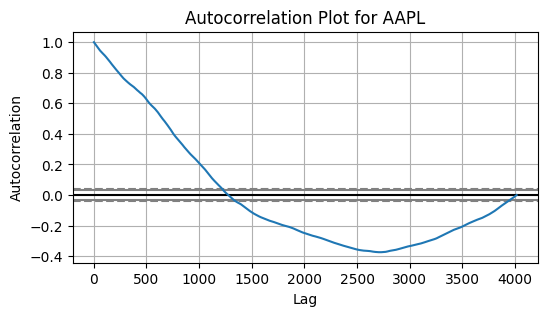

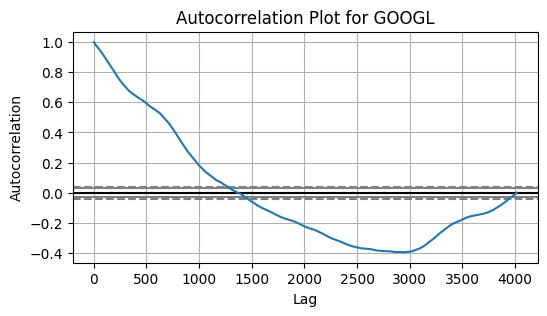

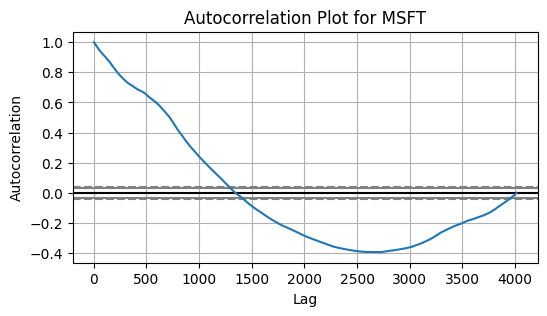

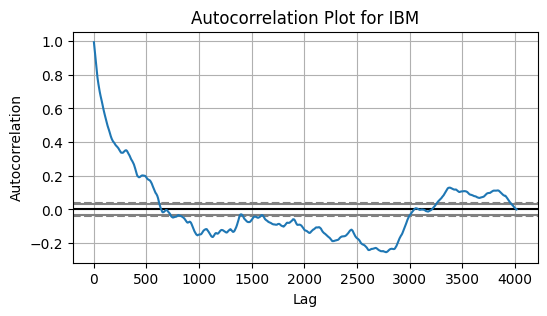

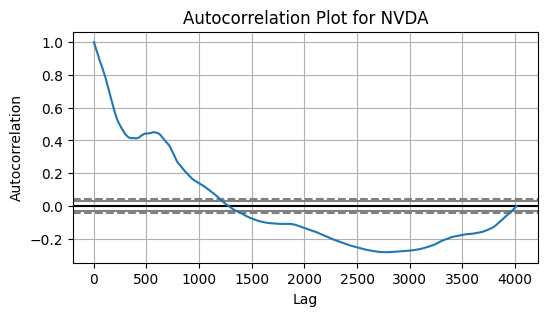

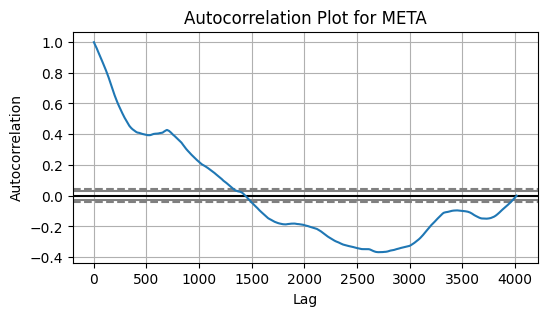

In [118]:
autocorr_plots(data)

correlation check ideas:  
Autocorrelation Function (ACF): The ACF plot can help identify seasonality. If there is significant seasonality, the ACF plot should show spikes at lags equal to the period.  
Statistical Tests: There are formal hypothesis tests available to detect seasonality, such as the Student T-Test and the Wilcoxon Signed Rank Test. These tests can be used to check if the observed seasonality is statistically significant.

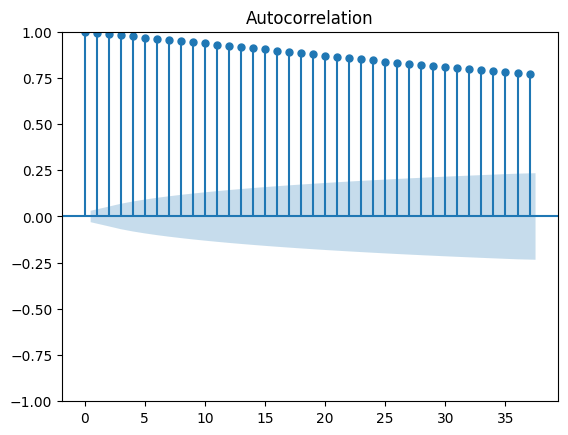

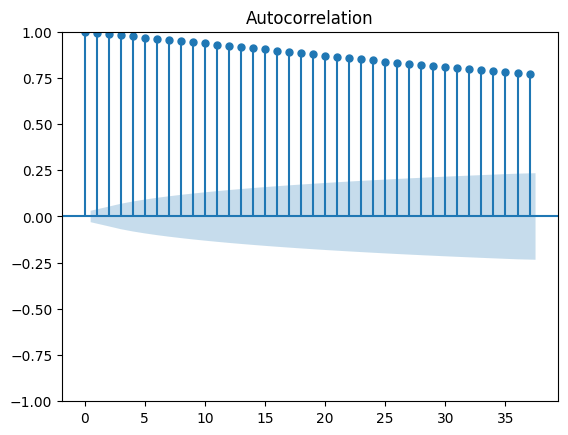

In [120]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data['IBM'])

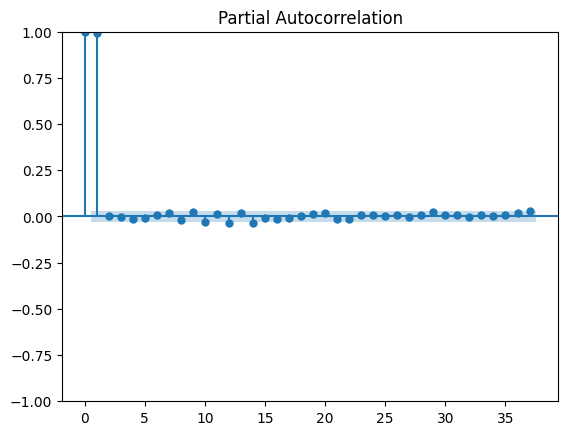

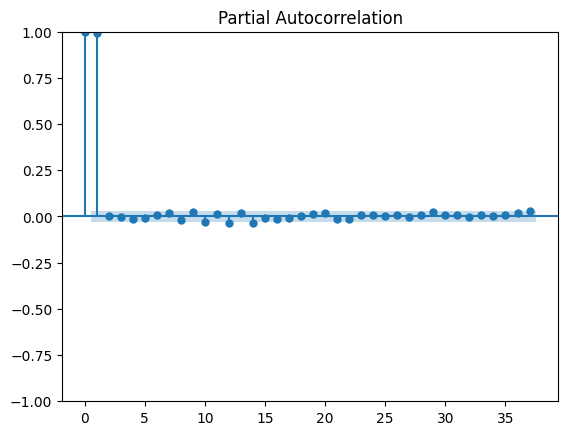

In [122]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data['IBM'])

### autocorrelation test

## Converting non - stationary data to stationary. 
differencing, log transformation, or a Box-Cox transformation. 

Statistical stationarity: A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time. Most statistical forecasting methods are based on the assumption that the time series can be rendered approximately stationary (i.e., "stationarized") through the use of mathematical transformations. A stationarized series is relatively easy to predict: you simply predict that its statistical properties will be the same in the future as they have been in the past!   (Recall our famous forecasting quotes.)  The predictions for the stationarized series can then be "untransformed," by reversing whatever mathematical transformations were previously used, to obtain predictions for the original series. (The details are normally taken care of by your software.) Thus, finding the sequence of transformations needed to stationarize a time series often provides important clues in the search for an appropriate forecasting model.  Stationarizing a time series through differencing (where needed) is an important part of the process of fitting an ARIMA model, as discussed in the ARIMA pages of these notes.

Another reason for trying to stationarize a time series is to be able to obtain meaningful sample statistics such as means, variances, and correlations with other variables. Such statistics are useful as descriptors of future behavior only if the series is stationary. For example, if the series is consistently increasing over time, the sample mean and variance will grow with the size of the sample, and they will always underestimate the mean and variance in future periods. And if the mean and variance of a series are not well-defined, then neither are its correlations with other variables. For this reason you should be cautious about trying to extrapolate regression models fitted to nonstationary data.

Most business and economic time series are far from stationary when expressed in their original units of measurement, and even after deflation or seasonal adjustment they will typically still exhibit trends, cycles, random-walking, and other non-stationary behavior.   If the series has a stable long-run trend and tends to revert to the trend line following a disturbance, it may be possible to stationarize it by de-trending (e.g., by fitting a trend line and subtracting it out prior to fitting a model, or else by including the time index as an independent variable in a regression or ARIMA model), perhaps in conjunction with logging or deflating.   Such a series is said to be trend-stationary.    However, sometimes even de-trending is not sufficient to make the series stationary, in which case it may be necessary to transform it into a series of period-to-period and/or season-to-season differences.  If the mean, variance, and autocorrelations of the original series are not constant in time, even after detrending, perhaps the statistics of the changes in the series between periods or between seasons will be constant.   Such a series is said to be difference-stationary.  (Sometimes it can be hard to tell the difference between a series that is trend-stationary and one that is difference-stationary, and a so-called unit root test may be used to get a more definitive answer.  We will return to this topic later in the course.)
(Return to top of page.)
source: https://people.duke.edu/~rnau/411diff.htm

In [123]:
def diff_series(dict):
    diff_dict = {}
    for ticker, series in dict.items():
        diff_df = series.diff().dropna()
        diff_dict[ticker] = diff_df
    return diff_dict


In [124]:
diff_data = diff_series(data)

In [126]:
#plot_dataframes(diff_data)

In [127]:
adf_panel_results = adf_test(diff_data)
adf_panel_results

,ticker,ADF Statistic,p-value,used_lag,nobs,Critical Value 1%,Critical Value 5%,Critical Value 10%
0,AAPL,-12.047503,2.643954e-22,25,3987,-3.431991,-2.862265,-2.567156
1,GOOGL,-13.101980,1.702501e-24,30,3982,-3.431993,-2.862266,-2.567157
2,MSFT,-13.114104,1.612353e-24,26,3986,-3.431992,-2.862265,-2.567156
3,IBM,-16.792189,1.239427e-29,12,4000,-3.431986,-2.862263,-2.567155
4,NVDA,-11.798419,9.457045e-22,31,3981,-3.431994,-2.862266,-2.567157
5,META,-15.527657,2.241446e-28,15,3997,-3.431987,-2.862263,-2.567155


In [128]:
import pandas as pd
import matplotlib.pyplot as plt

def histogram_plots(df_dict):
    for ticker, df in df_dict.items():
        fig, ax = plt.subplots(figsize=(6, 3))
        df.hist(ax=ax)
        plt.title(f'Histogram for {ticker}')
        plt.show()


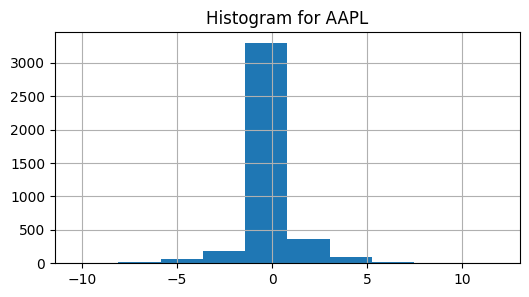

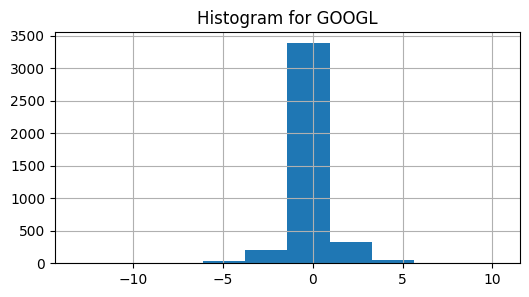

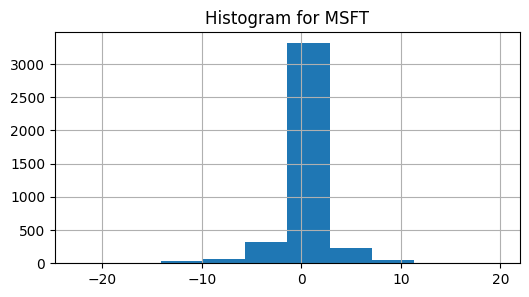

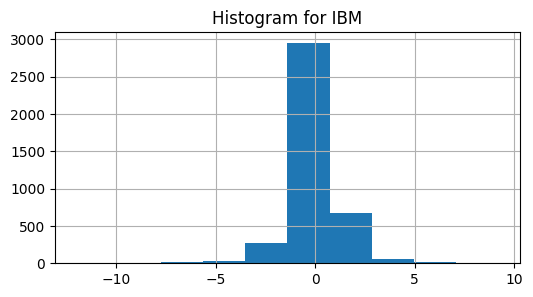

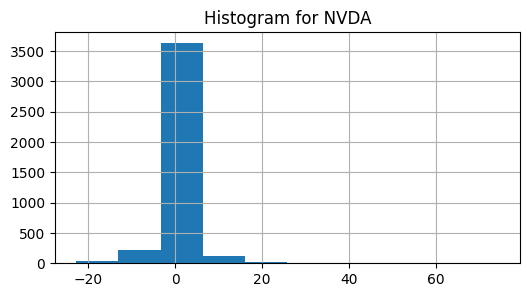

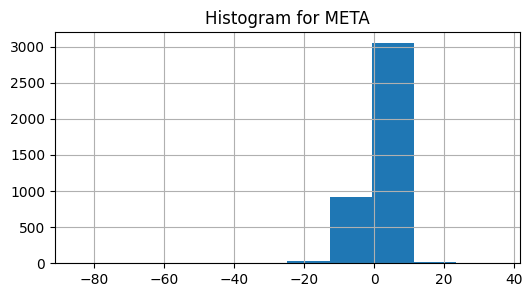

In [129]:
histogram_plots(diff_data)

### autocorrelation (diff data)

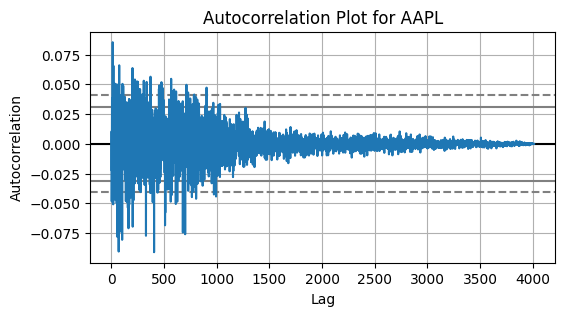

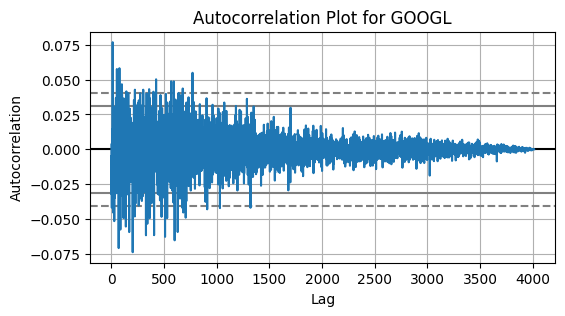

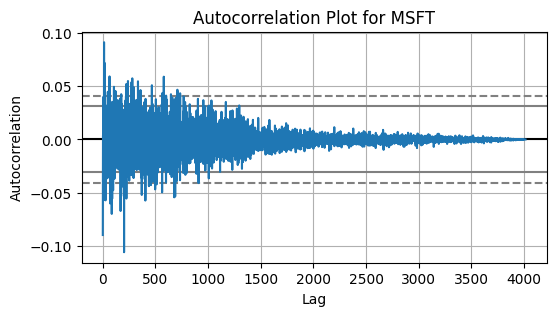

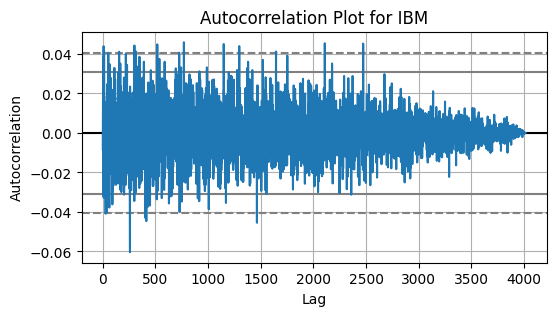

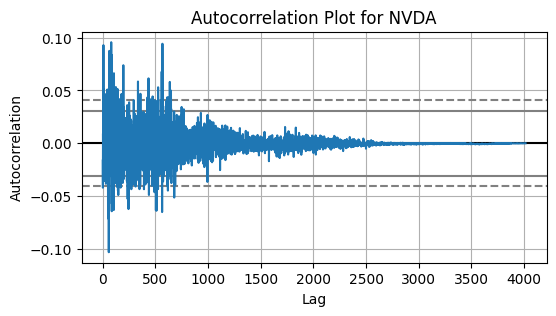

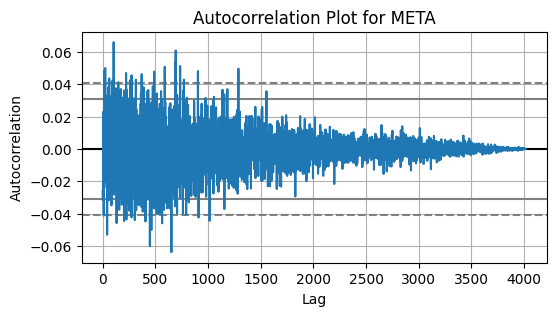

In [130]:
autocorr_plots(diff_data)

## data format testing

df = pd.DataFrame()

for stock, series in data.items():
    series.index.name = 'Date'
    df = df.append(series.reset_index().rename(columns={'index': 'Stock'}))

df.set_index(['Stock', 'Date'], inplace=True)


## Train / Test Split --> Start "data" for testing

### temporal split

In [179]:
data_ibm = diff_data['IBM'].iloc[-365: ,].to_frame()

In [180]:
data_ibm.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 365 entries, 2022-12-30 to 2023-12-29
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [183]:
data_ibm.describe()

,Close
count,365.000000
mean,0.079902
std,1.105676
min,-6.011444
25%,-0.199997
50%,0.000000
75%,0.530418
max,6.605087


In [ ]:
data

In [184]:
import matplotlib.pyplot as plt
from sktime.forecasting.model_selection import temporal_train_test_split

y_train, y_test = temporal_train_test_split(data_ibm, test_size=30)

#plt.figure(figsize=(10, 6))
#plt.plot(y_train.index, y_train, label='Train - Series 1')
#plt.plot(y_test.index, y_test, label='Test - Series 1')

#plt.legend()
#plt.show()


### sliding window [test]

In [ ]:
from sktime.forecasting.model_selection import SlidingWindowSplitter
#from sktime.forecasting.naive import NaiveForecaster


In [ ]:
#cv = SlidingWindowSplitter(fh=1, window_length=10, step_length=1)
window_size = 12 #define window size
sws = SlidingWindowSplitter(
    window_length=window_size,
    step_length=1) #set splitter

train_indices, test_indices = [], []
for train_index, test_index in sws.split(clean_ibm_filtered_diff):
    train_indices.append(train_index)
    test_indices.append(test_index)

sws.get_fh()



In [ ]:
sws.get_fh()


In [ ]:
y_train = train_indices[0]
y_test = test_indices[0]

## Model building

For example, in python and R, the auto ARIMA method itself will generate the optimal p and q parameters, which would be suitable for the data set to provide better forecasting. The high-level logic behind that is the same as the logic behind hyperparameter tuning of any other machine learning model. We need to try some combinations of p and q parameters and compare results using a validation set.

Since our search space is not big, usually values p and q are not higher than 10, we can apply a popular technique for hyperparameter optimization called grid search. Grid search is simply an exhaustive search through a manually specified subset of the hyperparameter space of a learning algorithm. Basically, it means that this method will try each combination of p and q from the specified subset that we provided.  
source: https://www.baeldung.com/cs/acf-pacf-plots-arma-modeling#:~:text=The%20autocorrelation%20function%20(ACF)%20is,number%20of%20periods%20or%20units.

In [ ]:
# ARIMA + gridearch SARIMA?

In [ ]:
#https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

In [ ]:
# check multiple train test splits from sktime!
#https://towardsdatascience.com/build-complex-time-series-regression-pipelines-with-sktime-910bc25c96b6

### Naive Forecaster

In [ ]:
y_train.describe() # .iloc[3200:3211]

In [ ]:
from sktime.forecasting.naive import NaiveForecaster

model_naiveforecaster = NaiveForecaster(strategy='drift', sp=1) # SP=1 is none (seasonality)
model_naiveforecaster.fit(y_train) # X=None, fh=None

In [ ]:
# Get the length of the test data
from sktime.forecasting.base import ForecastingHorizon

fh_n = ForecastingHorizon(y_test.index, is_relative=False)

#n = len(y_test)
#fh_n = list(range(1, n+1))
#print(n)

# predictions
yhat = model_naiveforecaster.predict(fh_n)
yhat.describe()

In [ ]:
import matplotlib.pyplot as plt
from sktime.forecasting.model_selection import temporal_train_test_split

plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label='Train - Series 1')
plt.plot(y_test.index, y_test, label='Test - Series 1')
plt.plot(yhat.index, yhat, label='predictions - Series 1')

#plt.plot(y_train2.index, y_train2, label='Train - Series 2')
#plt.plot(y_test2.index, y_test2, label='Test - Series 2')
plt.legend()
plt.show()


In [166]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_model(y_true, y_pred):
    mape = mean_absolute_error(y_true, y_pred) / np.mean(np.abs(y_true)) * 100
    smape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), np.abs(y_pred)))) * 200
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    
    print(f"Mean Absolute Percentage Error (MAPE): {mape}")
    print(f"Symmetric Mean Absolute Percentage Error (sMAPE): {smape}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")

In [ ]:
evaluate_model(y_test, yhat)

### autoARIMA

In [ ]:
#from pmdarima import AutoARIMA

In [ ]:
y_train.iloc[3200:3211, :]

In [175]:
y_test.shape, y_train.shape, y.shape

((30, 1), (335, 1), (4014,))

In [185]:
from statsmodels.tsa.arima.model import ARIMA
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from matplotlib import pyplot

fh_n = ForecastingHorizon(y_test.index, is_relative=False)

#n = len(y_test)
#fh_n = list(range(1, n+1))
#print(len(fh_n))

# create model
model_autoarima = AutoARIMA(start_p=0, max_p=30, sp=1, seasonal=False, suppress_warnings=True)

# fit model
model_autoarima.fit(y=y_train)
yhat = model_autoarima.predict(fh_n)
print(yhat.shape)

(30, 1)


In [186]:
results = pd.DataFrame()
results['y_test'] = y_test
results['yhat'] = yhat
results

,y_test,yhat
2023-11-30,2.149994,0.0
2023-12-01,1.990005,0.0
2023-12-02,0.000000,0.0
2023-12-03,0.000000,0.0
2023-12-04,0.550003,0.0
2023-12-05,0.289993,0.0
2023-12-06,-1.110001,0.0
2023-12-07,-0.059998,0.0
2023-12-08,1.740005,0.0
2023-12-09,0.000000,0.0


In [ ]:
import matplotlib.pyplot as plt
from sktime.forecasting.model_selection import temporal_train_test_split

plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label='Train - Series 1')
plt.plot(y_test.index, y_test, label='Test - Series 1')
plt.plot(yhat.index, yhat, label='predictions - Series 1')

#plt.plot(y_train2.index, y_train2, label='Train - Series 2')
#plt.plot(y_test2.index, y_test2, label='Test - Series 2')
plt.legend()
plt.show()


In [167]:
evaluate_model(y_test, yhat)

Mean Absolute Percentage Error (MAPE): 3.4144458887060463
Symmetric Mean Absolute Percentage Error (sMAPE): 6.815663625772149
Mean Squared Error (MSE): 32.365201464458366
Mean Absolute Error (MAE): 5.52933095296224


In [168]:
# summary of fit model
print(model_autoarima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  335
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -512.356
Date:                Mon, 29 Jan 2024   AIC                           1026.712
Time:                        02:17:16   BIC                           1030.523
Sample:                    12-30-2022   HQIC                          1028.232
                         - 11-29-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.2588      0.047     26.926      0.000       1.167       1.350
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               632.61
Prob(Q):                              0.81   Pr

In [176]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.split import ExpandingWindowSplitter
from sktime.split import SlidingWindowSplitter

cv = ExpandingWindowSplitter(
    step_length=12, fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], initial_window=72
)

df = evaluate(forecaster=model_autoarima, y=data_ibm, cv=cv, strategy="refit", return_data=True)

df.iloc[:, :5]

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff
0,0.009554,0.082782,0.003716,72,2023-03-11
1,0.044769,0.045720,0.002894,84,2023-03-23
2,0.015412,0.036823,0.002821,96,2023-04-04
3,0.014345,0.038016,0.003189,108,2023-04-16
4,0.017537,0.050549,0.002788,120,2023-04-28
5,0.023368,0.050201,0.002751,132,2023-05-10
6,0.015392,0.054360,0.002967,144,2023-05-22
7,0.020163,0.042596,0.002732,156,2023-06-03
8,0.036877,0.042250,0.002735,168,2023-06-15
9,0.007626,0.055560,0.002680,180,2023-06-27


### line plot residuals (?)

In [ ]:
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())